In [234]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\qg91v\appdata\local\temp\pip-req-build-b9rhzkfr
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\qg91v\AppData\Local\Temp\pip-req-build-b9rhzkfr'


In [114]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [98]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print('obs:', obs, 'reward:', reward, 'done:', done, 'info:', info)

    # Render the game
    # os.system("clear")
    # sys.stdout.write(env.render())
    # time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()

obs: (12, -1) reward: 1 done: False info: {'score': 0, 'player': [6, 6], 'distance': 12.041594578792296}
obs: (11, 0) reward: 1 done: False info: {'score': 0, 'player': [6, 7], 'distance': 11.0}
obs: (10, -1) reward: 1 done: False info: {'score': 0, 'player': [6, 6], 'distance': 10.04987562112089}
obs: (9, 0) reward: 1 done: False info: {'score': 0, 'player': [6, 7], 'distance': 9.0}
obs: (8, -1) reward: 1 done: False info: {'score': 0, 'player': [6, 6], 'distance': 8.06225774829855}
obs: (7, -2) reward: 1 done: False info: {'score': 0, 'player': [6, 5], 'distance': 7.280109889280518}
obs: (6, -1) reward: 1 done: False info: {'score': 0, 'player': [6, 6], 'distance': 6.082762530298219}
obs: (5, 2) reward: 1 done: False info: {'score': 0, 'player': [6, 9], 'distance': 5.385164807134504}
obs: (4, 7) reward: 1 done: False info: {'score': 0, 'player': [6, 14], 'distance': 8.06225774829855}
obs: (3, 6) reward: 1 done: False info: {'score': 0, 'player': [6, 13], 'distance': 6.708203932499369

In [3]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
    
    return np.random.choice(ties)

# Monte Carlo

In [152]:
class MonteCarloAgent:
    def __init__(self, env, alpha=0.1, gamma=1.0, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=1e-4):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon_start  # exploration rate
        self.epsilon_decay = epsilon_decay  # epsilon decay rate
        self.epsilon_min = epsilon_min  # minimum epsilon value
        self.Q = dict()  # state-action value function represented by a dictionary
        self.nA = env.action_space.n  # number of actions
        self.rewards = []  # list containing rewards for each episode
        self.scores = []  # list containing scores for each episode

    def generate_episode_from_Q(self):
        """ generates an episode from following the epsilon-greedy policy """
        episode = []
        state, info = env.reset()
        while True:
            action = np.random.choice(np.arange(self.nA), p=get_probs(self.Q[state], self.epsilon, self.nA)) \
                                        if state in self.Q else env.action_space.sample()
            # take a step in the environement 
            next_state, reward, done, _, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode, info['score']

    def get_probs(self, state):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        best_a = np.argmax(self.Q[state])
        policy_s[best_a] = 1 - self.epsilon + (self.epsilon / self.nA)
        return policy_s

    def update_Q(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            if state not in self.Q:
                self.Q[state] = np.zeros(self.nA)
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    
    def train(self, num_episodes, max_time=300):
        start = time.time()
        for i_episode in tqdm(range(1, num_episodes+1)):
            # set the value of epsilon
            self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)
            # generate an episode by following epsilon-greedy policy
            episode, score = self.generate_episode_from_Q()
            self.rewards.append(sum([step[2] for step in episode]))
            self.scores.append(score)
            # update the action-value function estimate using the episode
            self.update_Q(episode)
            if time.time() - start > max_time:
                break
        return self.Q, self.rewards, self.scores

In [222]:
# Twick the hyperparameters
alphas = [0.1, 0.2, 0.4]
epsilon_decays = [0.99999, 0.9999, 0.999]
parameters = [(alpha, epsilon_decay) for alpha in alphas for epsilon_decay in epsilon_decays]
mc_agents = []

for alpha, epsilon_decay in parameters:
    print(f'alpha: {alpha}, epsilon_decay: {epsilon_decay}')
    agent = MonteCarloAgent(env, alpha=alpha, epsilon_decay=epsilon_decay)
    Q_values, rewards, scores = agent.train(num_episodes=10000, max_time=300)
    mc_agents.append(agent)
    print('Best score:', max(scores))

alpha: 0.1, epsilon_decay: 0.99999


100%|██████████| 10000/10000 [00:11<00:00, 875.11it/s]


Best score: 6
alpha: 0.1, epsilon_decay: 0.9999


100%|██████████| 10000/10000 [00:16<00:00, 602.05it/s]


Best score: 21
alpha: 0.1, epsilon_decay: 0.999


 64%|██████▍   | 6398/10000 [05:00<02:48, 21.32it/s]  


Best score: 1483
alpha: 0.2, epsilon_decay: 0.99999


100%|██████████| 10000/10000 [00:11<00:00, 849.66it/s]


Best score: 4
alpha: 0.2, epsilon_decay: 0.9999


100%|██████████| 10000/10000 [00:16<00:00, 600.03it/s]


Best score: 12
alpha: 0.2, epsilon_decay: 0.999


 66%|██████▌   | 6610/10000 [05:01<02:34, 21.92it/s]  


Best score: 1226
alpha: 0.4, epsilon_decay: 0.99999


100%|██████████| 10000/10000 [00:11<00:00, 862.53it/s]


Best score: 5
alpha: 0.4, epsilon_decay: 0.9999


100%|██████████| 10000/10000 [00:16<00:00, 616.54it/s]


Best score: 9
alpha: 0.4, epsilon_decay: 0.999


 63%|██████▎   | 6272/10000 [05:14<03:07, 19.92it/s]  

Best score: 1270


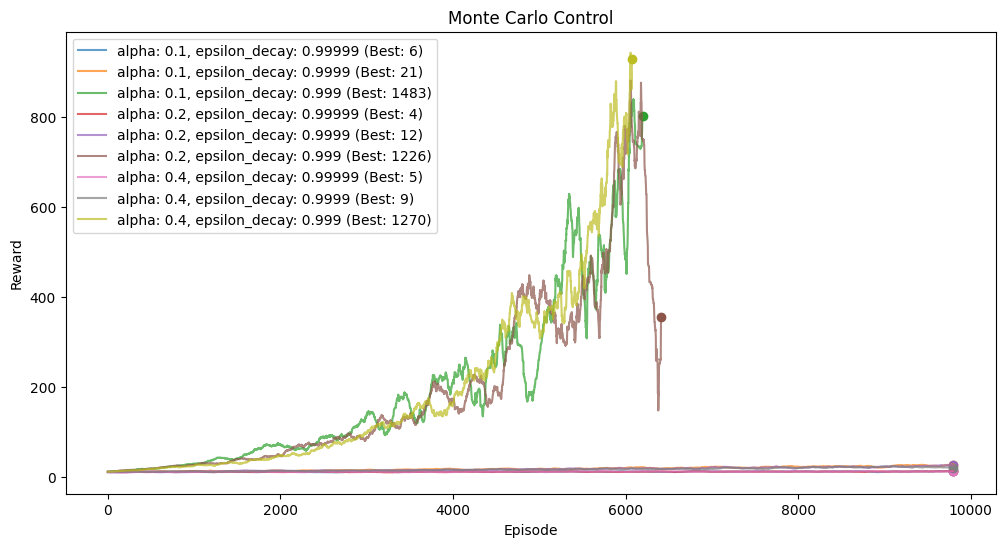

In [226]:

# Plot the rewards and moving average of rewards and score
plt.figure(figsize=(12, 6))

for i in range(len(mc_agents)):
    rewards = np.convolve(mc_agents[i].rewards, np.ones(200)/200, mode='valid')
    plt.plot(np.arange(len(rewards)),
             
             rewards,
             label=f'alpha: {parameters[i][0]}, epsilon_decay: {parameters[i][1]} (Best: {max(mc_agents[i].scores)})',
             alpha=0.7)
    color = plt.gca().lines[i].get_color()  # Get the color of the current curve
    plt.scatter(len(rewards)-1, rewards[-1], color=color)  # Add a point at the end with the same color

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte Carlo Control')
plt.legend()
plt.show()

In [156]:
# make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_flappy_values(V, agent_name, min_x=0, max_x=20, min_y=-12, max_y=12):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)
        
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
        ax.set_xlabel('Player\'s X Distance from Pipe')
        ax.set_ylabel('Player\'s Y Distance from Pipe')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(agent_name + ' State Value Plot')
    get_figure(ax)


def plot_policy_flappy(policy,agent_name, min_x=0, max_x=20, min_y=-12, max_y=12):
    
    def get_Z(x, y):
        if (x,y) in policy:
            return policy[x,y]
        else:
            return -1 # unexplored
    
    def get_figure(ax):
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape) 
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent'))
        plt.xticks(x_range) 
        plt.yticks(np.arange(23), range(-11, 12, 1))
        plt.gca().invert_xaxis() 
        ax.set_xlabel('X distance from Pipe') 
        ax.set_ylabel('Y distance from Pipe') 

        ax.grid(color='w', linestyle='-', linewidth=1) 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1) 
        cbar = plt.colorbar(surf, boundaries=[-1.5,-0.5,0.5,1.5], ticks=[-1,0,1], cax=cax) 
        cbar.ax.set_yticklabels(['Unexplored Region', 'Idle','Flap'])

    
    fig = plt.figure(figsize=(10, 10)) 
    ax = fig.add_subplot(111)
    ax.set_title(agent_name + ' Policy')
    get_figure(ax)
    plt.show() # show the plot


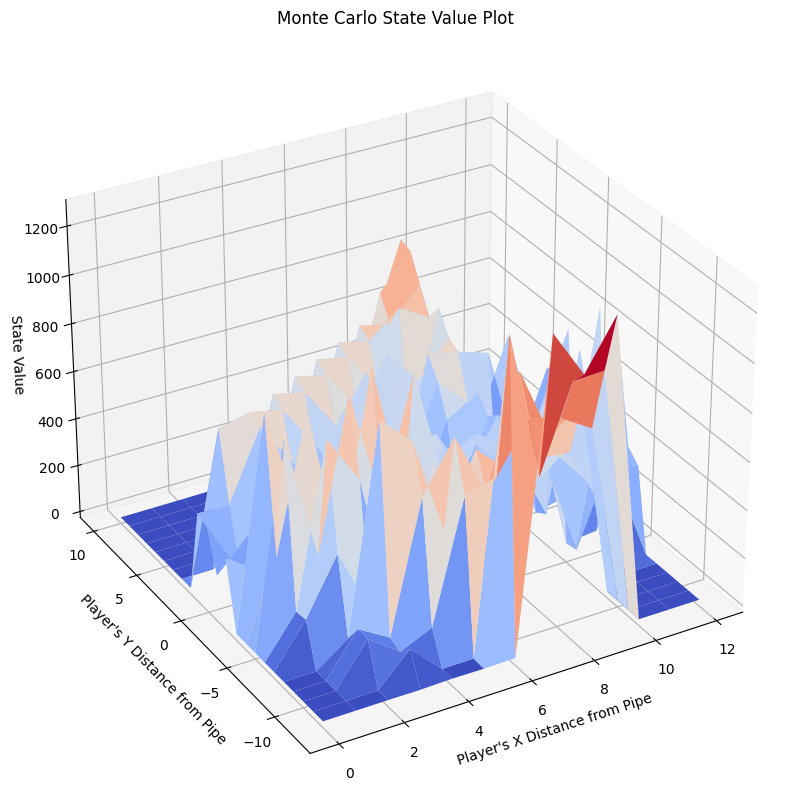

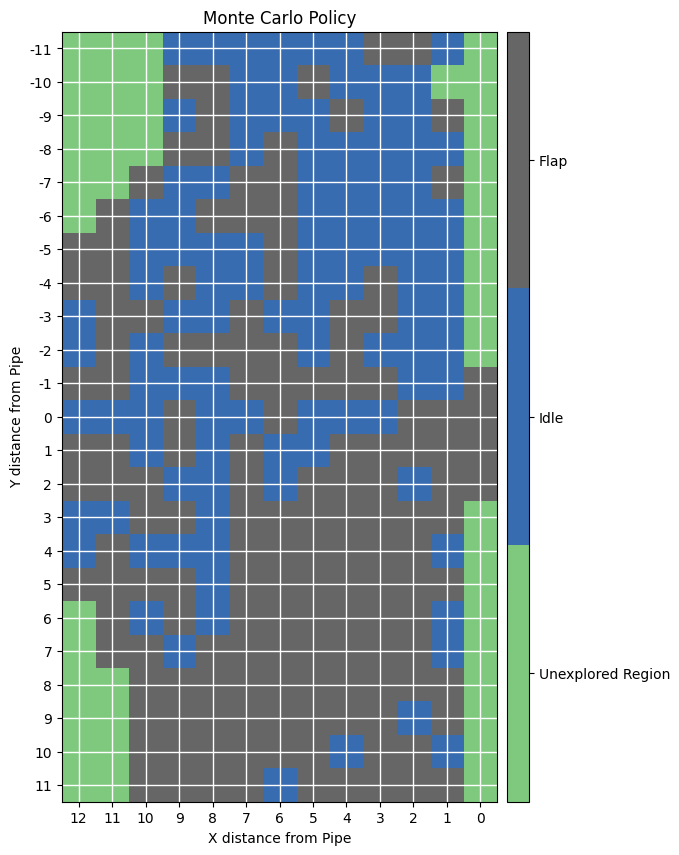

In [246]:
best_agent_mc = mc_agents[np.argmax([max(agent.scores) for agent in mc_agents])]

# Plot the state value function
V = dict((k,np.max(v)) for k, v in best_agent_mc.Q.items())
min_x = min(k[0] for k in V.keys())
max_x = max(k[0] for k in V.keys())
min_y = min(k[1] for k in V.keys())
max_y = max(k[1] for k in V.keys())
plot_flappy_values(V, 'Monte Carlo', min_x, max_x, min_y, max_y)

# Plot the policy
policy = dict((k, argmax(v)) for k, v in best_agent_mc.Q.items())
plot_policy_flappy(policy, 'Monte Carlo', min_x, max_x, min_y, max_y)

In [290]:
# Test in different environment configuration
Q = best_agent_mc.Q

for i in range(2, 6):
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = i)
    state, info = env.reset()
    done = False

    while not done:
        if state in Q:
            action = argmax(Q[state])
        else:
            action = env.action_space.sample()
        state, _, done, _, info = env.step(action)
        if info['score'] > 10000:
            print(f'Pipe gap: {i}, Score > 10000')
            break
    if info['score'] < 10000:
        print(f'Pipe gap: {i}, Score: {info["score"]}')
    

Pipe gap: 2, Score: 0
Pipe gap: 3, Score: 1
Pipe gap: 4, Score > 10000
Pipe gap: 5, Score > 10000


# Sarsa(λ)

In [228]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.99, epsilon_min=1e-4, lambd=0.9):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon_start  # exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambd = lambd  # eligibility trace decay factor
        self.Q = {}  # state-action value function represented by a dictionary
        self.E = {}  # eligibility trace represented by a dictionary
        self.rewards = []
        self.scores = []

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random action
            return self.env.action_space.sample()
        else:
            return argmax(self.Q[state])

    def update(self, state, action, reward, next_state, next_action, done):
        td_error = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
        self.E[state][action] += 1  # increment eligibility trace
        for s in self.Q.keys():
            for a in range(self.env.action_space.n):
                self.Q[s][a] += self.alpha * td_error * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambd  # decay eligibility trace

    def train(self, num_episodes, max_time=300):
        self.rewards = []
        start_time = time.time()
        for episode in tqdm(range(num_episodes)):
            self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

            episode_reward = 0
            state, _ = self.env.reset()
            
            if state not in self.Q:
                self.Q[state] = np.zeros(self.env.action_space.n)
                self.E[state] = np.zeros(self.env.action_space.n)

            action = self.choose_action(state)
            done = False

            # Reset eligibility trace
            for s in self.E.keys():
                self.E[s] = np.zeros(self.env.action_space.n)

            while not done:
                next_state, reward, done, _, info = self.env.step(action)
                if next_state not in self.Q:
                    self.Q[next_state] = np.zeros(self.env.action_space.n)
                    self.E[next_state] = np.zeros(self.env.action_space.n)
                episode_reward += reward
                next_action = self.choose_action(next_state)
                self.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            self.rewards.append(episode_reward)
            self.scores.append(info['score'])
            if time.time() - start_time > max_time:
                break
        return self.rewards, self.scores

In [229]:
alphas = [0.2, 0.4]
gammas = [0.99, 0.9]
lambdas = [0.99, 0.9]
parameters = [(alpha, gamma, lambd) for alpha in alphas for gamma in gammas for lambd in lambdas]
sarsa_agents = []

for alpha, gamma, lambd in parameters:
    print(f'alpha: {alpha}, gamma: {gamma}, lambd: {lambd}')
    agent = SarsaLambdaAgent(env, alpha=alpha, gamma=gamma, lambd=lambd)
    rewards, scores = agent.train(num_episodes=10000, max_time=300)
    sarsa_agents.append(agent)
    print('Best score:', max(scores))

alpha: 0.2, gamma: 0.99, lambd: 0.99


 30%|███       | 3006/10000 [05:00<11:38, 10.01it/s]


Best score: 81
alpha: 0.2, gamma: 0.99, lambd: 0.9


  7%|▋         | 684/10000 [05:06<1:09:35,  2.23it/s] 


Best score: 1239
alpha: 0.2, gamma: 0.9, lambd: 0.99


 20%|██        | 2044/10000 [05:00<19:27,  6.81it/s]  


Best score: 138
alpha: 0.2, gamma: 0.9, lambd: 0.9


 20%|██        | 2037/10000 [05:00<19:33,  6.78it/s]  


Best score: 112
alpha: 0.4, gamma: 0.99, lambd: 0.99


100%|██████████| 10000/10000 [03:13<00:00, 51.77it/s]


Best score: 18
alpha: 0.4, gamma: 0.99, lambd: 0.9


 10%|█         | 1042/10000 [05:00<42:59,  3.47it/s]  


Best score: 257
alpha: 0.4, gamma: 0.9, lambd: 0.99


 15%|█▍        | 1452/10000 [05:00<29:27,  4.84it/s]  


Best score: 160
alpha: 0.4, gamma: 0.9, lambd: 0.9


 10%|▉         | 973/10000 [06:56<1:04:27,  2.33it/s] 

Best score: 16676


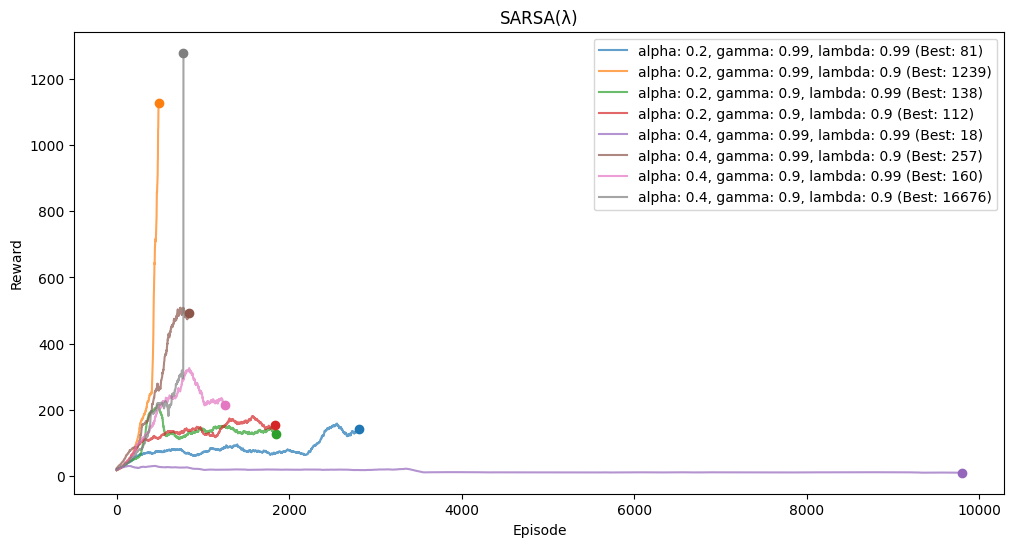

In [230]:
# Plot the rewards and moving average of rewards and score
plt.figure(figsize=(12, 6))
for i in range(len(sarsa_agents)):
    rewards = np.convolve(sarsa_agents[i].rewards, np.ones(200)/200, mode='valid')
    plt.plot(np.arange(len(rewards)),
             rewards,
             label=f'alpha: {parameters[i][0]}, gamma: {parameters[i][1]}, lambda: {parameters[i][2]} (Best: {max(sarsa_agents[i].scores)})',
             alpha=0.7)
    color = plt.gca().lines[i].get_color()  # Get the color of the current curve
    plt.scatter(len(rewards)-1, rewards[-1], color=color)  # Add a point at the end with the same color

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('SARSA(λ)')
plt.legend()
plt.show()

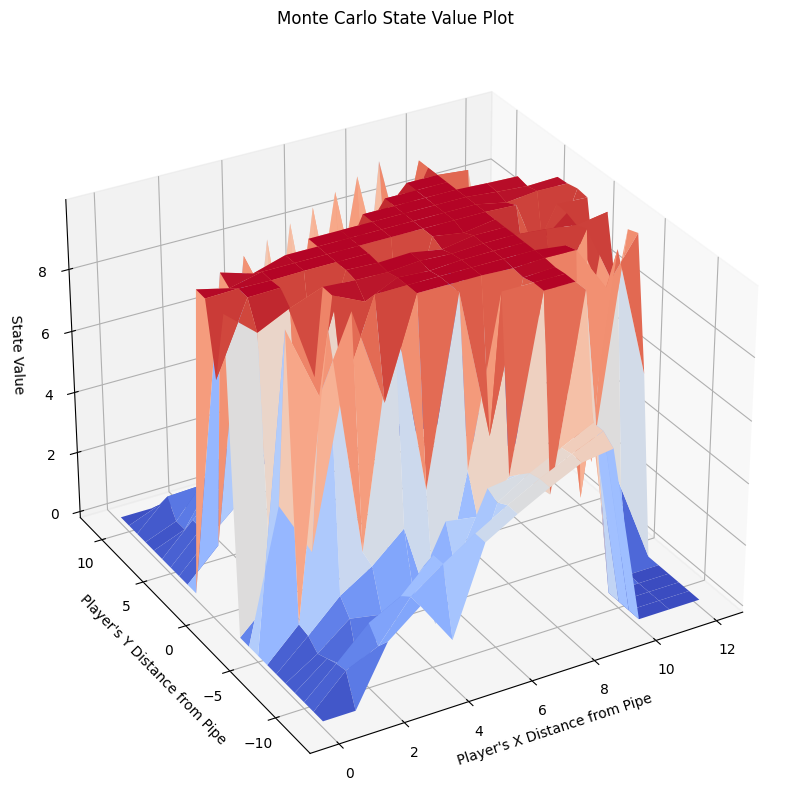

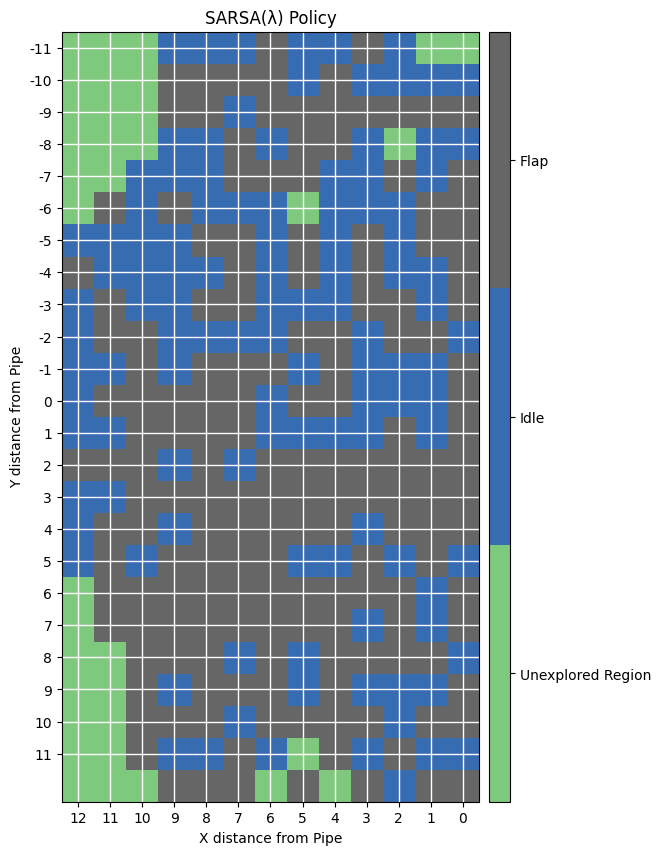

In [270]:
best_agent_sarsa = sarsa_agents[np.argmax([max(agent.scores) for agent in sarsa_agents])]

# Plot the state value function
V = dict((k,np.max(v)) for k, v in best_agent_sarsa.Q.items())
min_x = min(k[0] for k in V.keys())
max_x = max(k[0] for k in V.keys())
min_y = min(k[1] for k in V.keys())
max_y = max(k[1] for k in V.keys())
plot_flappy_values(V, 'Monte Carlo', min_x, max_x, min_y, max_y)

# Plot the policy
policy = dict((k, argmax(v)) for k, v in best_agent_sarsa.Q.items())
plot_policy_flappy(policy, 'SARSA(λ)', min_x, max_x, min_y, max_y)

In [293]:
# Test in different environment configuration
Q = best_agent_sarsa.Q

for i in range(2, 6):
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = i)
    state, info = env.reset()
    done = False

    while not done:
        if state in Q:
            action = argmax(Q[state])
        else:
            action = env.action_space.sample()
        state, _, done, _, info = env.step(action)
        if info['score'] > 10000:
            print(f'Pipe gap: {i}, Score > 10000')
            break
    if info['score'] < 10000:
        print(f'Pipe gap: {i}, Score: {info["score"]}')
    

Pipe gap: 2, Score: 2
Pipe gap: 3, Score: 3
Pipe gap: 4, Score > 10000
Pipe gap: 5, Score > 10000
